# Predict With FFNN

In [ ]:
# Membuat folder .kaggle di dalam folder root
!rm -rf ~/.kaggle && mkdir ~/.kaggle/

# Menyalin berkas kaggle.json pada direktori aktif saat ini ke folder .kaggle
!mv kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Mengunduh dataset menggunakan Kaggle CLI
!kaggle datasets download -d galaxyh/kdd-cup-1999-data

100% 87.8M/87.8M [00:00<00:00, 117MB/s] 
100% 87.8M/87.8M [00:00<00:00, 102MB/s]


In [ ]:
!unzip "/content/kdd-cup-1999-data.zip"

Archive:  /content/kdd-cup-1999-data.zip
  inflating: corrected.gz            
  inflating: corrected/corrected     
  inflating: kddcup.data.corrected   
  inflating: kddcup.data.gz          
  inflating: kddcup.data/kddcup.data  
  inflating: kddcup.data_10_percent.gz  
  inflating: kddcup.data_10_percent/kddcup.data_10_percent  
  inflating: kddcup.data_10_percent_corrected  
  inflating: kddcup.names            
  inflating: kddcup.newtestdata_10_percent_unlabeled.gz  
  inflating: kddcup.newtestdata_10_percent_unlabeled/kddcup.newtestdata_10_percent_unlabeled  
  inflating: kddcup.testdata.unlabeled.gz  
  inflating: kddcup.testdata.unlabeled/kddcup.testdata.unlabeled  
  inflating: kddcup.testdata.unlabeled_10_percent.gz  
  inflating: kddcup.testdata.unlabeled_10_percent/kddcup.testdata.unlabeled_10_percent  
  inflating: training_attack_types   
  inflating: typo-correction.txt     


# Import Library Yang Dibutuhkan

In [ ]:
import os
import shutil
import requests
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib as plt
from datetime import datetime

In [ ]:
# features dict and list
# we use kdd.cup names 

content = open('/content/kddcup.names', 'r').readlines()
content

['back,buffer_overflow,ftp_write,guess_passwd,imap,ipsweep,land,loadmodule,multihop,neptune,nmap,normal,perl,phf,pod,portsweep,rootkit,satan,smurf,spy,teardrop,warezclient,warezmaster.\n',
 'duration: continuous.\n',
 'protocol_type: symbolic.\n',
 'service: symbolic.\n',
 'flag: symbolic.\n',
 'src_bytes: continuous.\n',
 'dst_bytes: continuous.\n',
 'land: symbolic.\n',
 'wrong_fragment: continuous.\n',
 'urgent: continuous.\n',
 'hot: continuous.\n',
 'num_failed_logins: continuous.\n',
 'logged_in: symbolic.\n',
 'num_compromised: continuous.\n',
 'root_shell: continuous.\n',
 'su_attempted: continuous.\n',
 'num_root: continuous.\n',
 'num_file_creations: continuous.\n',
 'num_shells: continuous.\n',
 'num_access_files: continuous.\n',
 'num_outbound_cmds: continuous.\n',
 'is_host_login: symbolic.\n',
 'is_guest_login: symbolic.\n',
 'count: continuous.\n',
 'srv_count: continuous.\n',
 'serror_rate: continuous.\n',
 'srv_serror_rate: continuous.\n',
 'rerror_rate: continuous.\n'

In [ ]:
buf, *features = content
attack_types = buf.split(',')
attack_types[-1] = attack_types[-1][:-1]
features_types_dict = {f.split(':')[0]: f.split(':')[1][1:-2] for f in features}
features = list(features_types_dict.keys())
features_types_dict

{'count': 'continuous',
 'diff_srv_rate': 'continuous',
 'dst_bytes': 'continuous',
 'dst_host_count': 'continuous',
 'dst_host_diff_srv_rate': 'continuous',
 'dst_host_rerror_rate': 'continuous',
 'dst_host_same_src_port_rate': 'continuous',
 'dst_host_same_srv_rate': 'continuous',
 'dst_host_serror_rate': 'continuous',
 'dst_host_srv_count': 'continuous',
 'dst_host_srv_diff_host_rate': 'continuous',
 'dst_host_srv_rerror_rate': 'continuous',
 'dst_host_srv_serror_rate': 'continuous',
 'duration': 'continuous',
 'flag': 'symbolic',
 'hot': 'continuous',
 'is_guest_login': 'symbolic',
 'is_host_login': 'symbolic',
 'land': 'symbolic',
 'logged_in': 'symbolic',
 'num_access_files': 'continuous',
 'num_compromised': 'continuous',
 'num_failed_logins': 'continuous',
 'num_file_creations': 'continuous',
 'num_outbound_cmds': 'continuous',
 'num_root': 'continuous',
 'num_shells': 'continuous',
 'protocol_type': 'symbolic',
 'rerror_rate': 'continuous',
 'root_shell': 'continuous',
 'same_

In [ ]:
# get attack types dict 
# we use data training_attack_types 

content = open ('/content/training_attack_types', 'r').readlines()
content

['back dos\n',
 'buffer_overflow u2r\n',
 'ftp_write r2l\n',
 'guess_passwd r2l\n',
 'imap r2l\n',
 'ipsweep probe\n',
 'land dos\n',
 'loadmodule u2r\n',
 'multihop r2l\n',
 'neptune dos\n',
 'nmap probe\n',
 'perl u2r\n',
 'phf r2l\n',
 'pod dos\n',
 'portsweep probe\n',
 'rootkit u2r\n',
 'satan probe\n',
 'smurf dos\n',
 'spy r2l\n',
 'teardrop dos\n',
 'warezclient r2l\n',
 'warezmaster r2l\n',
 '\n']

In [ ]:
buf = content[:-1]
target_classes = {
    'normal' : 0,
    'u2r' : 1,
    'r2l' : 2,
    'probe' : 3,
    'dos' : 4
}
attack_types_dict = {line.split()[0]: line.split()[1] for line in buf}
attack_types_dict['normal'] = 'normal'
attack_types_dict

{'back': 'dos',
 'buffer_overflow': 'u2r',
 'ftp_write': 'r2l',
 'guess_passwd': 'r2l',
 'imap': 'r2l',
 'ipsweep': 'probe',
 'land': 'dos',
 'loadmodule': 'u2r',
 'multihop': 'r2l',
 'neptune': 'dos',
 'nmap': 'probe',
 'normal': 'normal',
 'perl': 'u2r',
 'phf': 'r2l',
 'pod': 'dos',
 'portsweep': 'probe',
 'rootkit': 'u2r',
 'satan': 'probe',
 'smurf': 'dos',
 'spy': 'r2l',
 'teardrop': 'dos',
 'warezclient': 'r2l',
 'warezmaster': 'r2l'}

In [ ]:
# Load data
# make sure we join 'label' in the df
data_file = '/content/kddcup.data.gz'
data = pd.read_csv(data_file,
                   header = None,
                   names = features + ['label'])
data['label'] = [i[:-1] for i in data['label'].values]
data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,label
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.0,normal
1,0,tcp,http,SF,162,4528,0,0,0,0,...,1,1.0,0.0,1.00,0.00,0.0,0.00,0.0,0.0,normal
2,0,tcp,http,SF,236,1228,0,0,0,0,...,2,1.0,0.0,0.50,0.00,0.0,0.00,0.0,0.0,normal
3,0,tcp,http,SF,233,2032,0,0,0,0,...,3,1.0,0.0,0.33,0.00,0.0,0.00,0.0,0.0,normal
4,0,tcp,http,SF,239,486,0,0,0,0,...,4,1.0,0.0,0.25,0.00,0.0,0.00,0.0,0.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4898426,0,tcp,http,SF,212,2288,0,0,0,0,...,255,1.0,0.0,0.33,0.05,0.0,0.01,0.0,0.0,normal
4898427,0,tcp,http,SF,219,236,0,0,0,0,...,255,1.0,0.0,0.25,0.05,0.0,0.01,0.0,0.0,normal
4898428,0,tcp,http,SF,218,3610,0,0,0,0,...,255,1.0,0.0,0.20,0.05,0.0,0.01,0.0,0.0,normal
4898429,0,tcp,http,SF,219,1234,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.0,0.01,0.0,0.0,normal


# Unnormalized Features

In [ ]:
# numerical features
num_attrs = []
for i in [0, 4, 5, 7, 8, 9, 12, 13, 14, 15, 16, 17, 18, 22, 31,32]:
  num_attrs.append(features[i])
num_attrs

['duration',
 'src_bytes',
 'dst_bytes',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'count',
 'dst_host_count',
 'dst_host_srv_count']

In [ ]:
# categorical features
cat_attrs = []
for i in [1, 2, 3]:
  cat_attrs.append(features[i])
cat_attrs

['protocol_type', 'service', 'flag']

# Data Classification

In [ ]:
label_counts_dict = data['label'].value_counts()
print('+', '-' * 8, '+', '-' * 17, '+', '-' * 9, '+', sep='')
print('|%-7s |%-16s |%-8s |' % ('Class', "Attack type", 'Count'))
print('+', '-' * 8, '+', '-' * 17, '+', '-' * 9, '+', sep='')
for (count, attack_type) in zip(label_counts_dict, label_counts_dict.keys()):
    print('|%-7s |%-16s |%-8d |' % (attack_types_dict[attack_type], attack_type, count))
    print('+', '-' * 8, '+', '-' * 17, '+', '-' * 9, '+', sep='')

+--------+-----------------+---------+
|Class   |Attack type      |Count    |
+--------+-----------------+---------+
|dos     |smurf            |2807886  |
+--------+-----------------+---------+
|dos     |neptune          |1072017  |
+--------+-----------------+---------+
|normal  |normal           |972781   |
+--------+-----------------+---------+
|probe   |satan            |15892    |
+--------+-----------------+---------+
|probe   |ipsweep          |12481    |
+--------+-----------------+---------+
|probe   |portsweep        |10413    |
+--------+-----------------+---------+
|probe   |nmap             |2316     |
+--------+-----------------+---------+
|dos     |back             |2203     |
+--------+-----------------+---------+
|r2l     |warezclient      |1020     |
+--------+-----------------+---------+
|dos     |teardrop         |979      |
+--------+-----------------+---------+
|dos     |pod              |264      |
+--------+-----------------+---------+
|r2l     |guess_passwd   

In [ ]:
# Deteksi kelas kecil dan banyak 
num_class = ['smurf', 'neptune', 'normal']
small_class = [cl for cl in attack_types if cl not in num_class]
small_class, num_class

(['back',
  'buffer_overflow',
  'ftp_write',
  'guess_passwd',
  'imap',
  'ipsweep',
  'land',
  'loadmodule',
  'multihop',
  'nmap',
  'perl',
  'phf',
  'pod',
  'portsweep',
  'rootkit',
  'satan',
  'spy',
  'teardrop',
  'warezclient',
  'warezmaster.'],
 ['smurf', 'neptune', 'normal'])

In [ ]:
# Training, Test, Validation Dataframes

train_df, test_df, val_df = data[1:2], data[2:3], data[3:4]

TRAIN_NUM = 15000
TEST_NUM = 1500

for cl in num_class:
  train_df = train_df.merge(data[data['label']==cl][:TRAIN_NUM], how = 'outer')
  test_df = test_df.merge(data[data['label']==cl][TRAIN_NUM:TRAIN_NUM+TEST_NUM], how = 'outer')
  val_df = val_df.merge(data[data['label']==cl][TRAIN_NUM+TEST_NUM:TRAIN_NUM+TEST_NUM+TEST_NUM], how = 'outer')

for cl in small_class:
  TRAIN_NUM = round(len(data[data['label']==cl]) * 0.8)
  TEST_NUM = round(len(data[data['label']==cl]) * 0.1)
  train_df = train_df.merge(data[data['label']==cl][:TRAIN_NUM], how = 'outer')
  test_df = test_df.merge(data[data['label']==cl][TRAIN_NUM:TRAIN_NUM+TEST_NUM], how = 'outer')
  val_df = val_df.merge(data[data['label']==cl][TRAIN_NUM+TEST_NUM:TRAIN_NUM+TEST_NUM+TEST_NUM], how = 'outer')

print('train_df: ', len(train_df))
print('test_df: ', len(test_df))
print('val_df: ', len(val_df))

train_df:  81581
test_df:  9072
val_df:  9070


# Random Forest

In [ ]:
from sklearn.preprocessing import LabelBinarizer, MinMaxScaler

# Definisikan pipeline untuk Random Forest
def pipeline(data):
  df = data.copy()
  cat_encoder = LabelBinarizer()
  scaler = MinMaxScaler()
  for attr in cat_attrs:
    df[attr] = cat_encoder.fit_transform(df[attr].values.reshape(-1,1))
  for attr in num_attrs:
    df[attr] = scaler.fit_transform(df[attr].values.reshape(-1,1))
  return df

In [ ]:
# Fit Random Forest untuk melihat feature importance

from sklearn.ensemble import RandomForestClassifier

train_data = pipeline(train_df)
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(train_data.drop('label', axis=1), train_data['label'])

RandomForestClassifier(n_estimators=500, n_jobs=-1)

In [ ]:
# Training Akurasi
from sklearn.metrics import accuracy_score

test_data = pipeline(test_df)
target = test_data.pop('label')
test_predict = rnd_clf.predict(test_data)
accuracy_score(target, test_predict)

0.9899691358024691

# Determine Feature Importance

In [ ]:
# Berdasarkan hasil RandomForest, akan ditentukan features importance nya

print('+','-' * 25, '+' , '-' * 15, '+', sep='')
print('|%-24s |%-s|' %('Feature', 'Importance(in %)'))
print('+','-' * 25, '+' , '-' * 15, '+', sep='')
for (feature, importance) in zip(features_types_dict, rnd_clf.feature_importances_):
  print('|%-28s|%-16f|' % (feature, importance * 100))


+-------------------------+---------------+
|Feature                  |Importance(in %)|
+-------------------------+---------------+
|duration                    |0.213345        |
|protocol_type               |4.848592        |
|service                     |0.000000        |
|flag                        |0.005808        |
|src_bytes                   |4.025283        |
|dst_bytes                   |0.310420        |
|land                        |0.009429        |
|wrong_fragment              |0.712162        |
|urgent                      |0.001199        |
|hot                         |0.744133        |
|num_failed_logins           |0.014534        |
|logged_in                   |6.189414        |
|num_compromised             |0.682319        |
|root_shell                  |0.010021        |
|su_attempted                |0.000435        |
|num_root                    |0.006787        |
|num_file_creations          |0.009137        |
|num_shells                  |0.001886        |
|nu

In [ ]:
d = {i : imp for i, imp in enumerate(rnd_clf.feature_importances_)}
for bias in [0.00, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06]:
  print('>', bias * 100, '%', len(list(filter(lambda x:d[x] > bias, d))))

> 0.0 % 39
> 1.0 % 22
> 2.0 % 20
> 3.0 % 17
> 4.0 % 11
> 5.0 % 8
> 6.0 % 4


In [ ]:
# Mendefuinisikan data pipeline untuk model neural network
def df_to_dataset(input_df, main_df=data, bias = 0.05, shuffle=True, batch_size=32):

    df = input_df.copy()
    cat_encoder = LabelBinarizer()
    scaler = MinMaxScaler()
    for attr in cat_attrs:
        cat_encoder.fit(main_df[attr].values.reshape(-1, 1))
        df[attr] = cat_encoder.transform(df[attr].values.reshape(-1, 1))
    for attr in num_attrs:
        scaler.fit(main_df[attr].values.reshape(-1, 1))
        df[attr] = scaler.fit_transform(df[attr].values.reshape(-1, 1))
            
    d = dict(zip(features, rnd_clf.feature_importances_))
    df = df.drop(list(filter(lambda x: d[x] < bias, d)), axis=1)

    df['label'] = df['label'].apply(lambda x: target_classes[attack_types_dict[x]])
    df['label'], _ = df['label'].factorize()
        
    labels = df.pop('label')
    dataset = tf.data.Dataset.from_tensor_slices((df.values, labels))
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(df))
    dataset = dataset.batch(batch_size)
    print(f'Features count: {len(df.columns)}')
    print('Сlass distribution: ', dict(labels.value_counts()))
    return dataset

In [ ]:
# Train, Test, Val 
BATCH_SIZE = 32
BIAS = 0.03

train_dataset = df_to_dataset(train_df, bias=BIAS, batch_size=BATCH_SIZE)
val_dataset = df_to_dataset(val_df, bias=BIAS, batch_size=BATCH_SIZE)
test_dataset = df_to_dataset(test_df,bias=BIAS, batch_size=BATCH_SIZE)

Features count: 17
Сlass distribution:  {4: 32882, 1: 32773, 0: 15000, 3: 885, 2: 41}
Features count: 17
Сlass distribution:  {4: 4109, 1: 3346, 0: 1501, 3: 109, 2: 5}
Features count: 17
Сlass distribution:  {4: 4110, 1: 3346, 0: 1501, 3: 110, 2: 5}


# Define Model

In [ ]:
def get_compiled_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(14, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dropout(0.3),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    model.compile(optimizer='adam',
                loss='sparse_categorical_crossentropy',
                metrics=['accuracy'])
    return model

In [ ]:
# Compile dan fit model
model = get_compiled_model()
epochs = 20
history = model.fit(train_dataset, 
                    validation_data=val_dataset, 
                    use_multiprocessing=True, 
                    epochs=epochs,
                   )

Epoch 1/20
2550/2550 [==============================] - 11s 3ms/step - loss: 0.8489 - accuracy: 0.7678 - val_loss: 0.1715 - val_accuracy: 0.9564
Epoch 2/20
2550/2550 [==============================] - 11s 4ms/step - loss: 0.3386 - accuracy: 0.8917 - val_loss: 0.1483 - val_accuracy: 0.9562
Epoch 3/20
2550/2550 [==============================] - 12s 5ms/step - loss: 0.2763 - accuracy: 0.9071 - val_loss: 0.1420 - val_accuracy: 0.9584
Epoch 4/20
2550/2550 [==============================] - 8s 3ms/step - loss: 0.2535 - accuracy: 0.9100 - val_loss: 0.1417 - val_accuracy: 0.9584
Epoch 5/20
2550/2550 [==============================] - 7s 3ms/step - loss: 0.2328 - accuracy: 0.9230 - val_loss: 0.1363 - val_accuracy: 0.9581
Epoch 6/20
2550/2550 [==============================] - 7s 3ms/step - loss: 0.2299 - accuracy: 0.9238 - val_loss: 0.1414 - val_accuracy: 0.9579
Epoch 7/20
2550/2550 [==============================] - 7s 3ms/step - loss: 0.2262 - accuracy: 0.9257 - val_loss: 0.1349 - val_accura

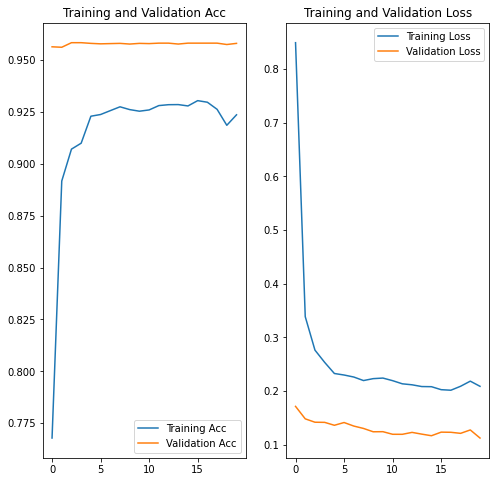

In [ ]:
# Cek Kurva Akurasi dan Loss 
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Acc')
plt.plot(epochs_range, val_acc, label='Validation Acc')
plt.legend(loc='lower right')
plt.title('Training and Validation Acc')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# cek akurasi pada data tes 
test_loss, test_accuracy = model.evaluate(test_dataset)
print('Acc on test dataset:', test_accuracy)

284/284 [==============================] - 1s 2ms/step - loss: 0.1024 - accuracy: 0.9586
Acc on test dataset: 0.9585537910461426


In [ ]:
def labels_to_list(data):
    df = data.copy()
    df['label'] = df['label'].apply(lambda x: target_classes[attack_types_dict[x]])
    df['label'], _ = df['label'].factorize()
    return df['label'].values.tolist()

In [ ]:
# Cek confusion matrix pada dataset tes and dapatkan classification report
from sklearn.metrics import classification_report, confusion_matrix

predict_labels = model.predict(df_to_dataset(test_df, bias=BIAS, shuffle=False, batch_size=BATCH_SIZE))
predicted_labels = [np.argmax(predict) for predict in predict_labels]
true_labels = labels_to_list(test_df)
print('\nConfusion matrix:\n', confusion_matrix(true_labels, predicted_labels))
print('\nClassification report:\n', classification_report(true_labels, predicted_labels))

Features count: 17
Сlass distribution:  {4: 4110, 1: 3346, 0: 1501, 3: 110, 2: 5}

Confusion matrix:
 [[1492    0    0    0    9]
 [ 220 3095    0    0   31]
 [   5    0    0    0    0]
 [ 107    1    0    0    2]
 [   1    0    0    0 4109]]

Classification report:
               precision    recall  f1-score   support

           0       0.82      0.99      0.90      1501
           1       1.00      0.92      0.96      3346
           2       0.00      0.00      0.00         5
           3       0.00      0.00      0.00       110
           4       0.99      1.00      0.99      4110

    accuracy                           0.96      9072
   macro avg       0.56      0.58      0.57      9072
weighted avg       0.95      0.96      0.95      9072



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
